# Step 1: Data Collection

In [1]:
import pandas_datareader as pdr

In [2]:
key="f15f38269f3d0b5b4eb89da55ae0890c311047c6"
df = pdr.get_data_tiingo('TCS', api_key=key)

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [3]:
df.to_csv('TCS.csv')

In [4]:
import pandas as pd
import numpy as np

In [5]:
df=pd.read_csv('TCS.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TCS,2018-11-12 00:00:00+00:00,6.14,6.22,5.980,6.02,218818,5.776789,5.852056,5.626254,5.663887,218818,0.0,1.0
1,TCS,2018-11-13 00:00:00+00:00,5.93,6.14,5.820,6.14,314338,5.579211,5.776789,5.475718,5.776789,314338,0.0,1.0
2,TCS,2018-11-14 00:00:00+00:00,5.92,6.13,5.860,6.04,219525,5.569803,5.767380,5.513352,5.682704,219525,0.0,1.0
3,TCS,2018-11-15 00:00:00+00:00,5.99,6.00,5.780,5.87,185725,5.635662,5.645070,5.438085,5.522761,185725,0.0,1.0
4,TCS,2018-11-16 00:00:00+00:00,5.73,5.95,5.535,5.94,342033,5.391042,5.598028,5.207577,5.588620,342033,0.0,1.0


In [6]:
len(df)

1258

In [7]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,TCS,2023-11-06 00:00:00+00:00,1.91,1.9200,1.845,1.89,110042,1.91,1.9200,1.845,1.89,110042,0.0,1.0
1254,TCS,2023-11-07 00:00:00+00:00,1.89,1.9372,1.870,1.88,113552,1.89,1.9372,1.870,1.88,113552,0.0,1.0
1255,TCS,2023-11-08 00:00:00+00:00,1.87,1.9200,1.860,1.86,72757,1.87,1.9200,1.860,1.86,72757,0.0,1.0
1256,TCS,2023-11-09 00:00:00+00:00,1.80,1.8800,1.770,1.88,212623,1.80,1.8800,1.770,1.88,212623,0.0,1.0
1257,TCS,2023-11-10 00:00:00+00:00,1.83,1.8432,1.730,1.82,164373,1.83,1.8432,1.730,1.82,164373,0.0,1.0


In [8]:
df=df.reset_index()['close']
df

0       6.14
1       5.93
2       5.92
3       5.99
4       5.73
        ... 
1253    1.91
1254    1.89
1255    1.87
1256    1.80
1257    1.83
Name: close, Length: 1258, dtype: float64

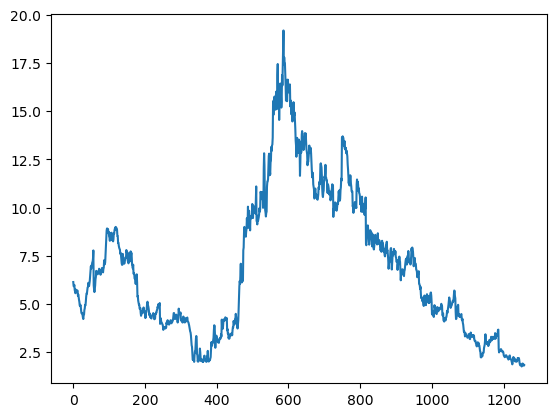

In [9]:
import matplotlib.pyplot as plt
plt.plot(df)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [11]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
print(len(train_data))
print(len(test_data))

817
441


In [13]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [14]:
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [15]:
print(Y_train.shape)

(716,)


# Step 2: LSTM 

In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam 

In [17]:
import lightning as L
from torch.utils.data import TensorDataset, DataLoader

In [18]:
class LightningLSTM(L.LightningModule):

    def __init__(self): # __init__() is the class constructor function, and we use it to initialize the Weights and Biases.
        
        super().__init__() # initialize an instance of the parent class, LightningModule.
    
        self.lstm = nn.LSTM(input_size=1, hidden_size=1) 
        

    def forward(self, input):
        ## transpose the input vector
        input_trans = input.view(len(input), 1)
        
        lstm_out, temp = self.lstm(input_trans)
        
        prediction = lstm_out[-1] 
        return prediction
        
        
    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        return Adam(self.parameters(), lr=0.0001) ## we'll just go ahead and set the learning rate to 0.1

    
    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        input_i, label_i = batch # collect input
        output_i = self.forward(input_i[0]) # run input through the neural network
        loss = (output_i - label_i)**2 ## loss = squared residual
        
        self.log("train_loss", loss)
        
        self.log("output", output_i)
        
        return loss

# Step 3: Model Training 

In [20]:
inputs = torch.tensor(X_train.tolist())
labels = torch.tensor(Y_train.tolist())

#x_train = [[0., 0.5, 0.25, 1.], [0.5, 0.25, 1., 0.5]]
#y_train = [0.5, 1.]

#inputs = torch.tensor(x_train)
#labels = torch.tensor(y_train)

dataset = TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)

In [21]:
model = LightningLSTM()

trainer = L.Trainer(max_epochs=200, log_every_n_steps=2)
trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 16    
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


In [22]:
def prediction(input):
    predicted_values = []
    for i in range(len(input)):
        x = model.forward(torch.tensor(input[i]).detach())
        predicted_values.append((x.detach()).item())
    return predicted_values

In [25]:
def mean_square_error(predicted_values, actual_values):
    
    Len = len(actual_values)
    mse = 0
    for i in range(Len):
        mse += (actual_values[i] - predicted_values[i])**2
    mse/=Len       
    return mse

In [26]:
predicted_values = prediction(X_test.tolist())

In [27]:
print(mean_square_error(predicted_values, Y_test))

0.00041845512547430334


In [28]:
predicted_values=scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
Y_test=scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))

# Plot of Predicted values and Actual values

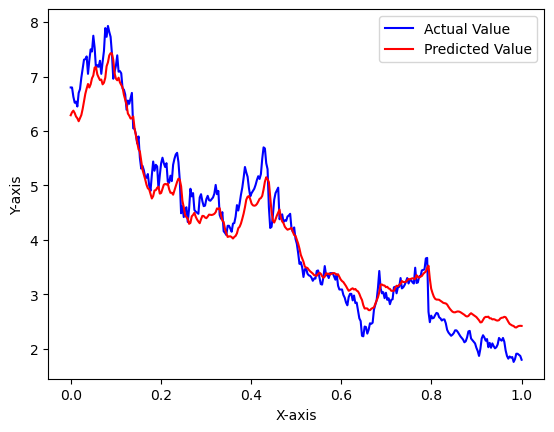

In [30]:
x = np.linspace(0, 1, 340)

# Plot the first set of data in blue
plt.plot(x, Y_test, label='Actual Value', color='blue')

# Plot the second set of data in red
plt.plot(x, predicted_values, label='Predicted Value', color='red')

# Add labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Display the plot
plt.show()